# Explainability in Credit Decisions

This project leveraged SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to audit an XGBoost credit risk model for potential biases. Here’s a summary of key findings and recommendations:

**Ethical & Regulatory Considerations**

- Transparency: SHAP/LIME explanations provide audit trails for compliance with regulations like EU’s AI Act or U.S. ECOA.
- Stakeholder Communication: Use visualizations (e.g., SHAP dependence plots) to justify model behavior to regulators and customers.

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress some SHAP/LIME warnings

## Load Data

In [2]:
# Define the zip file path
zip_file = "Home Credit Default Risk Dataset.zip"
extract_folder = "home_credit_data"  # Folder to extract files into

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)  # Extract files

# List all extracted files
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

# Load CSV files into DataFrames with proper encoding handling
csv_files = [f for f in extracted_files if f.endswith(".csv")]
dataframes = {}

for file in csv_files:
    file_path = os.path.join(extract_folder, file)
    df_name = file.replace(".csv", "")  # Name without .csv extension
    
    try:
        # Try reading with UTF-8 encoding
        dataframes[df_name] = pd.read_csv(file_path, encoding="utf-8")
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try ISO-8859-1 (common for non-UTF8 files)
            dataframes[df_name] = pd.read_csv(file_path, encoding="ISO-8859-1")
        except UnicodeDecodeError:
            # If both fail, try Latin-1 as a last resort
            dataframes[df_name] = pd.read_csv(file_path, encoding="latin1")
    
    print(f"Loaded {file} into DataFrame: {df_name}")

# Example: Access the 'HC_application_train' DataFrame
application_train_df = dataframes.get("HC_application_train")
print(application_train_df.head())  # Print first few rows

Extracted files: ['EDA_merged.ipynb', 'HC_application_train.csv', 'HC_bureau.csv', 'HC_bureau_balance.csv', 'HC_credit_card_balance.csv', 'HC_installments_payments.csv', 'HC_POS_CASH_balance.csv', 'HC_previous_application.csv', 'HC_sample_submission.csv', 'HomeCredit_columns_description.csv', 'Model ML_Logisctic Regression.ipynb', 'Model ML_Random Forest.ipynb', 'Model ML_XGBoost.ipynb', 'Model_LGBM.ipynb', 'Preprocessing_merged.ipynb']
Loaded HC_application_train.csv into DataFrame: HC_application_train
Loaded HC_bureau.csv into DataFrame: HC_bureau
Loaded HC_bureau_balance.csv into DataFrame: HC_bureau_balance
Loaded HC_credit_card_balance.csv into DataFrame: HC_credit_card_balance
Loaded HC_installments_payments.csv into DataFrame: HC_installments_payments
Loaded HC_POS_CASH_balance.csv into DataFrame: HC_POS_CASH_balance
Loaded HC_previous_application.csv into DataFrame: HC_previous_application
Loaded HC_sample_submission.csv into DataFrame: HC_sample_submission
Loaded HomeCredit_c

In [3]:
print(application_train_df.info())
print(application_train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.

## Data Clean

In [4]:
# Check for missing values
print(application_train_df.isnull().sum().sort_values(ascending=False))

# Check unique values in categorical columns
categorical_cols = application_train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(application_train_df[col].value_counts())

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

CODE_GENDER:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

FLAG_OWN_CAR:
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

FLAG_OWN_REALTY:
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

NAME_TYPE_SUITE:
NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271

In [5]:
# Handle Missing Values

# For numeric columns, fill with median (less sensitive to outliers)
numeric_cols = application_train_df.select_dtypes(include=['int64', 'float64']).columns
application_train_df[numeric_cols] = application_train_df[numeric_cols].fillna(application_train_df[numeric_cols].median())

# For categorical columns, fill with mode (most frequent value)
categorical_cols = application_train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    application_train_df[col] = application_train_df[col].fillna(application_train_df[col].mode()[0])

In [6]:
# Handle Outliers (visible in the summary statistics)

# Cap extreme values in numeric columns
def cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(lower, upper)
    return df

numeric_cols_to_cap = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
for col in numeric_cols_to_cap:
    application_train_df = cap_outliers(application_train_df, col)

## Feature Engineering

In [7]:
# Create new features that might be useful
application_train_df['CREDIT_INCOME_RATIO'] = application_train_df['AMT_CREDIT'] / application_train_df['AMT_INCOME_TOTAL']
application_train_df['ANNUITY_INCOME_RATIO'] = application_train_df['AMT_ANNUITY'] / application_train_df['AMT_INCOME_TOTAL']
application_train_df['EMPLOYED_TO_BIRTH_RATIO'] = application_train_df['DAYS_EMPLOYED'] / application_train_df['DAYS_BIRTH']

C:\Users\milto\AppData\Local\Temp\ipykernel_12492\3893523575.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train_df['CREDIT_INCOME_RATIO'] = application_train_df['AMT_CREDIT'] / application_train_df['AMT_INCOME_TOTAL']
C:\Users\milto\AppData\Local\Temp\ipykernel_12492\3893523575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train_df['ANNUITY_INCOME_RATIO'] = application_train_df['AMT_ANNUITY'] / application_train_df['AMT_INCOME_TOTAL']
C:\Users\milto\AppData\Local\Temp\ipykernel_12492\38935235

In [8]:
# Encode Categorical Variables

# One-hot encode categorical variables (for simpler models)
application_train_df = pd.get_dummies(application_train_df, drop_first=True)

# Alternatively, for tree-based models you might want to use label encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in categorical_cols:
#     application_train_df[col] = le.fit_transform(application_train_df[col].astype(str))

In [9]:
# Handle Special Cases

# DAYS_EMPLOYED has some very large positive values (likely indicating unemployed)
# Create a flag for this and replace the anomalous values
application_train_df['DAYS_EMPLOYED_ANOM'] = application_train_df['DAYS_EMPLOYED'] == 365243
application_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Then fill the NaN values (created above) with 0 or median
application_train_df['DAYS_EMPLOYED'].fillna(0, inplace=True)

C:\Users\milto\AppData\Local\Temp\ipykernel_12492\2964778101.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [10]:
# Final Check

# Verify no missing values remain
print(application_train_df.isnull().sum().sum())

# Check data types
print(application_train_df.info())

# Verify distributions
print(application_train_df.describe())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 234 entries, SK_ID_CURR to DAYS_EMPLOYED_ANOM
dtypes: bool(125), float64(69), int64(40)
memory usage: 292.4 MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000     307511.000000   
mean   278180.518577       0.080729       0.417052     166067.479607   
std    102790.175348       0.272419       0.722121      83000.171936   
min    100002.000000       0.000000       0.000000      45000.000000   
25%    189145.500000       0.000000       0.000000     112500.000000   
50%    278202.000000       0.000000       0.000000     147150.000000   
75%    367142.500000       0.000000       1.000000     202500.000000   
max    456255.000000       1.000000      19.000000     472500.000000   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307511.000000     3.075110e+05   
mean   5.963060e+05   26945.208570  

In [11]:
# Check data types
application_train_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,False,False,False,False,False,False,True,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,False,False,False,False,False,True,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,False,False,False,False,False,True,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,False,False,False,False,False,True,False,False,False,False


## Train a Credit Scoring Model

I trained model (e.g.XGBoost).

In [12]:
# Load data
X = application_train_df.drop('TARGET', axis=1)
y = application_train_df['TARGET']

# Convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Model Evaluation


Model Evaluation Metrics:
Accuracy: 0.7306
Precision: 0.1724
Recall: 0.6177
F1 Score: 0.2696
ROC AUC: 0.7451
Average Precision: 0.2287

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56554
           1       0.17      0.62      0.27      4949

    accuracy                           0.73     61503
   macro avg       0.56      0.68      0.55     61503
weighted avg       0.89      0.73      0.79     61503



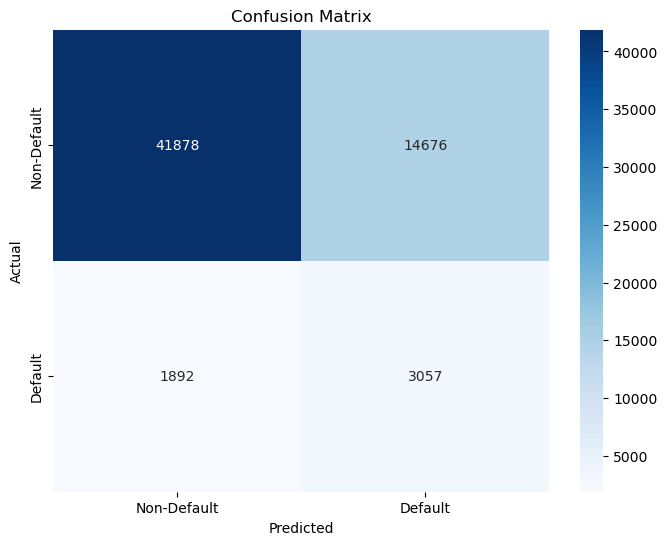

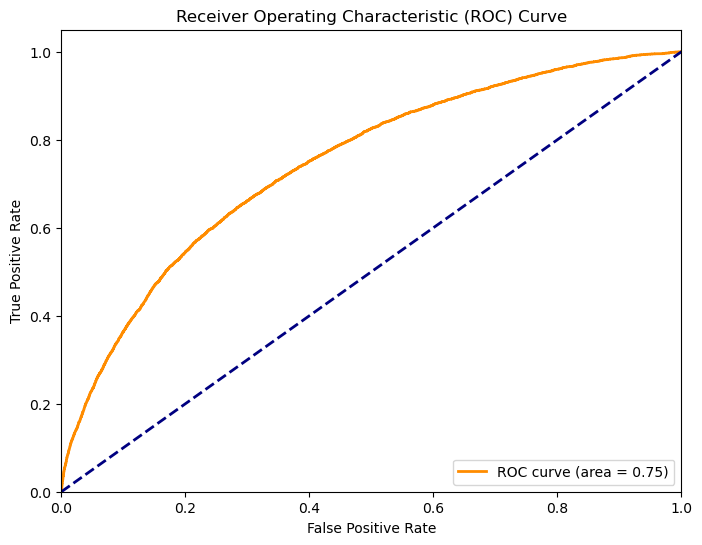

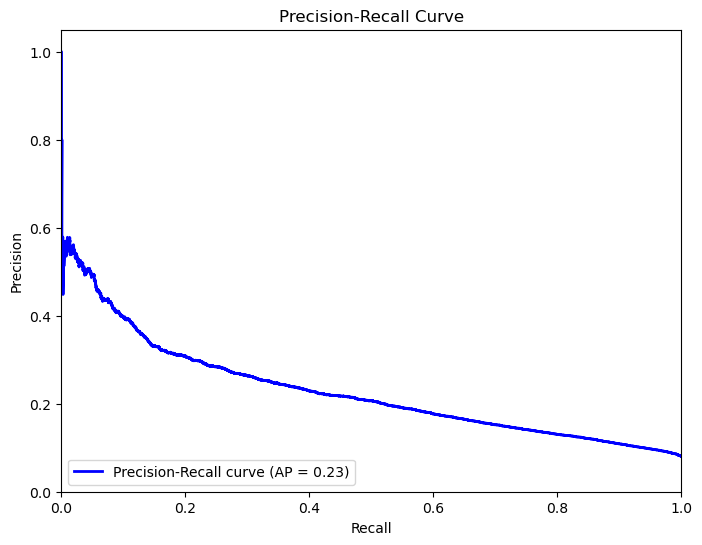

In [15]:
# Predict probabilities and classes
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
y_pred = model.predict(X_test)  # Binary predictions

# Calculate evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report, 
                            roc_curve, precision_recall_curve, auc)

# Basic metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Interpretation:

- Class Imbalance: The dataset has 56,554 non-defaults (class 0) vs. only 4,949 defaults (class 1).
- Accuracy (73.1%): Misleading due to imbalance - the model could predict all as non-default and still get ~92% accuracy.
- Precision (17.2%) for Defaults: Only 17% of predicted defaults are actual defaults. High false positive rate.
- Recall (61.8%) for Defaults: Captures 62% of actual defaults, which is decent for risk management.
- F1 Score (0.27): Poor balance between precision and recall for defaults.
- ROC AUC (0.745): Moderate discrimination power (1=perfect, 0.5=random).

**Key Insight**: The model is over-predicting defaults (low precision) but catches most true defaults (good recall). This may be acceptable for conservative risk assessment but will unnecessarily flag many good applicants.

## Data Preparation for Bias Analysis

Prepares the dataset for explainability analysis.

In [19]:
## Prepare Data for Bias Analysis
# Encode protected attributes if they exist (example attributes - adjust based on your dataset)
protected_attributes = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
categorical_cols = application_train_df.select_dtypes(include=['object']).columns

# Label encode categorical variables for SHAP/LIME
label_encoders = {}
for col in categorical_cols:
    if col in application_train_df.columns:
        le = LabelEncoder()
        application_train_df[col] = le.fit_transform(application_train_df[col].astype(str))
        label_encoders[col] = le

# Re-prepare X and y after encoding
X = application_train_df.drop('TARGET', axis=1)
y = application_train_df['TARGET']
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SHAP Analysis for Bias Detection

Quantifies how each feature (especially protected attributes) impacts model predictions.


SHAP Bias Analysis


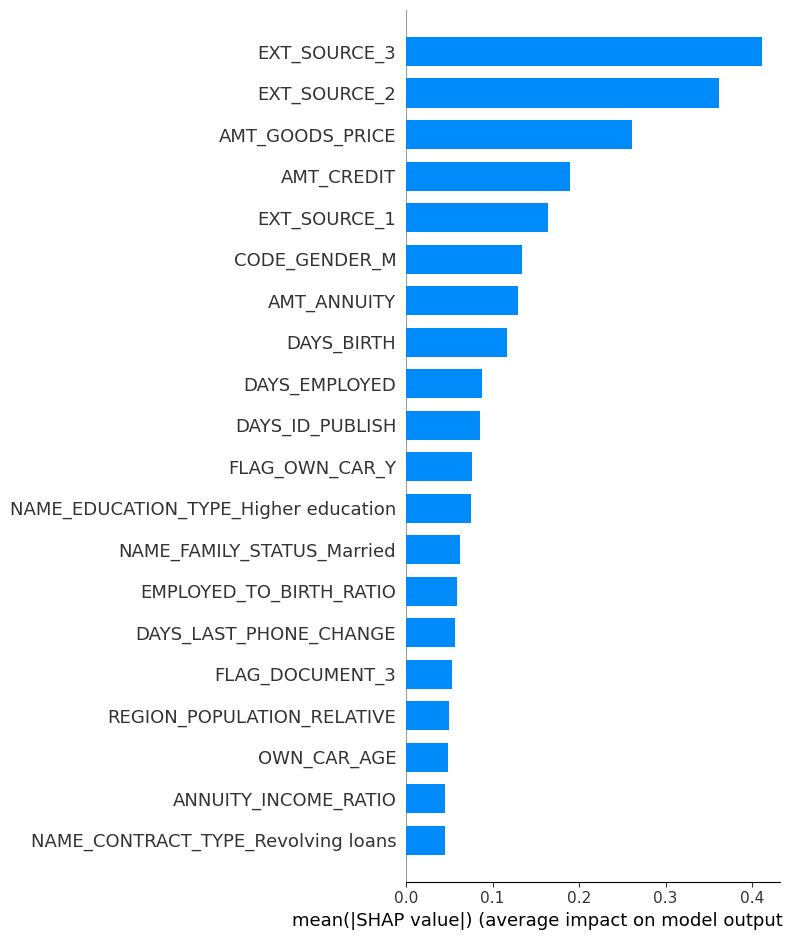

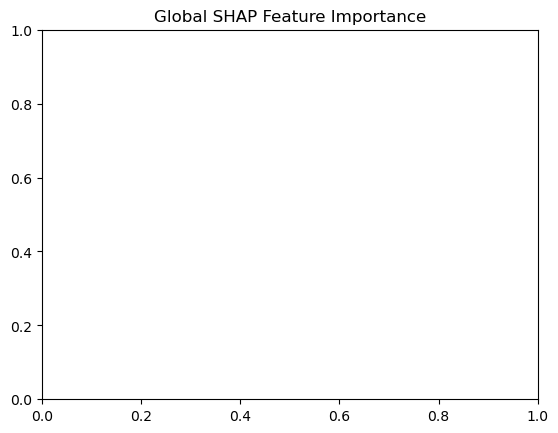

In [20]:
## 2. Enhanced SHAP Analysis for Bias Detection
def shap_bias_analysis(model, X, protected_attributes):
    """Analyze model for potential bias using SHAP values"""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    print("\nSHAP Bias Analysis")
    print("="*50)
    
    # 1. Global feature importance
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=20)
    plt.title('Global SHAP Feature Importance')
    plt.show()
    
    # 2. Dependency plots for protected attributes
    for attr in protected_attributes:
        if attr in X.columns:
            plt.figure(figsize=(8, 6))
            shap.dependence_plot(attr, shap_values, X, interaction_index=None)
            plt.title(f'SHAP Dependence Plot for {attr}')
            plt.show()
    
    # 3. Compare SHAP distributions between groups
    for attr in protected_attributes:
        if attr in X.columns:
            unique_values = X[attr].unique()
            if len(unique_values) > 1:
                print(f"\nSHAP Distribution Comparison for {attr}:")
                # Compare each pair of groups
                for val1, val2 in combinations(unique_values, 2):
                    group1_shap = shap_values[X[attr] == val1]
                    group2_shap = shap_values[X[attr] == val2]
                    
                    # KS test for distribution differences
                    ks_stat, p_value = ks_2samp(group1_shap.flatten(), group2_shap.flatten())
                    print(f"Groups {val1} vs {val2}: KS stat={ks_stat:.4f}, p-value={p_value:.4f}")

# Run SHAP bias analysis
shap_bias_analysis(model, X_test, protected_attributes)

## LIME for Local Explainability

Explains individual predictions to identify bias in specific cases.


LIME Explanation for Instance 29765
Actual class: 1 (0=Non-Default, 1=Default)
Predicted probabilities: [Non-Default: 0.4386, Default: 0.5614]


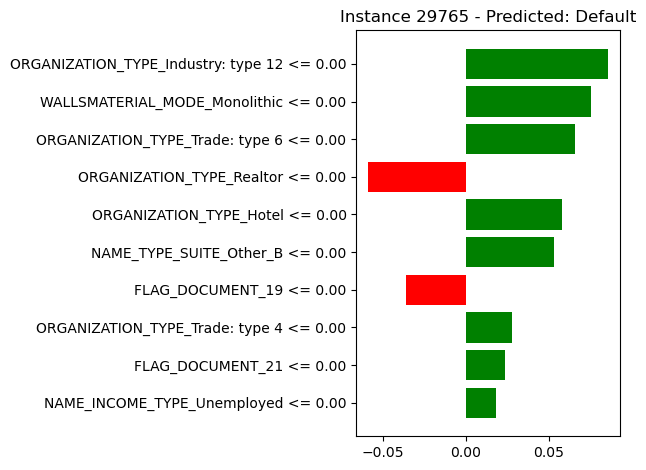


Protected Attributes:

Top Features Influencing Prediction:
ORGANIZATION_TYPE_Industry: type 12 <= 0.00: 0.0858
WALLSMATERIAL_MODE_Monolithic <= 0.00: 0.0756
ORGANIZATION_TYPE_Trade: type 6 <= 0.00: 0.0661
ORGANIZATION_TYPE_Realtor <= 0.00: -0.0589
ORGANIZATION_TYPE_Hotel <= 0.00: 0.0579

LIME Explanation for Instance 245895
Actual class: 0 (0=Non-Default, 1=Default)
Predicted probabilities: [Non-Default: 0.2951, Default: 0.7049]


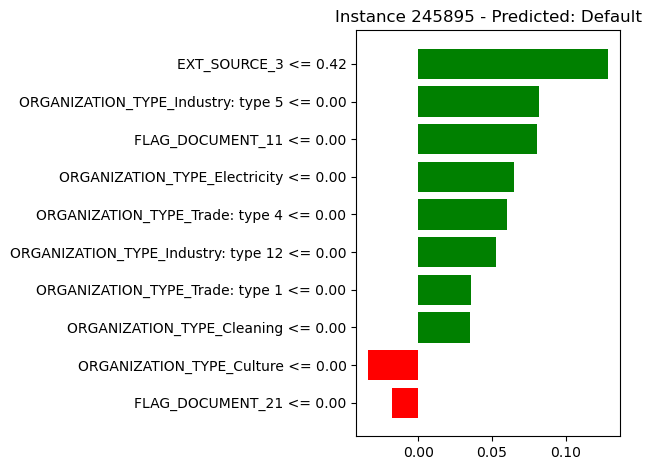


Protected Attributes:

Top Features Influencing Prediction:
EXT_SOURCE_3 <= 0.42: 0.1286
ORGANIZATION_TYPE_Industry: type 5 <= 0.00: 0.0820
FLAG_DOCUMENT_11 <= 0.00: 0.0806
ORGANIZATION_TYPE_Electricity <= 0.00: 0.0648
ORGANIZATION_TYPE_Trade: type 4 <= 0.00: 0.0604

LIME Explanation for Instance 238766
Actual class: 0 (0=Non-Default, 1=Default)
Predicted probabilities: [Non-Default: 0.0955, Default: 0.9045]


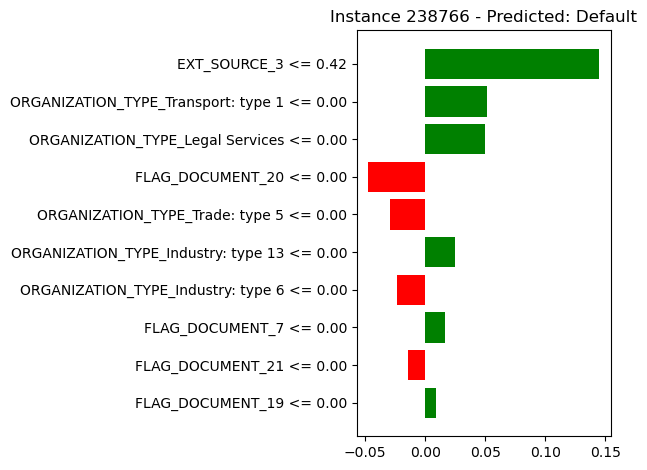


Protected Attributes:

Top Features Influencing Prediction:
EXT_SOURCE_3 <= 0.42: 0.1448
ORGANIZATION_TYPE_Transport: type 1 <= 0.00: 0.0517
ORGANIZATION_TYPE_Legal Services <= 0.00: 0.0501
FLAG_DOCUMENT_20 <= 0.00: -0.0472
ORGANIZATION_TYPE_Trade: type 5 <= 0.00: -0.0294


In [21]:
## Robust LIME Analysis with Complete Error Handling
def lime_analysis(model, X_train, X_test, y_test, protected_attributes):
    """Perform LIME analysis with comprehensive error handling"""
    # Create LIME explainer with safe defaults
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['Non-Default', 'Default'],
        mode='classification',
        discretize_continuous=True,
        kernel_width=3,
        verbose=False
    )
    
    # Get valid indices that exist in both X_test and y_test
    valid_indices = X_test.index.intersection(y_test.index)
    
    # Get balanced sample of instances to explain
    def get_valid_samples(n=3):
        samples = []
        # Try to get at least one default and one non-default
        if len(y_test[y_test == 1]) > 0:
            samples.append(y_test[y_test == 1].index[0])
        if len(y_test[y_test == 0]) > 0:
            samples.append(y_test[y_test == 0].index[0])
        # Fill remaining with random samples
        remaining = n - len(samples)
        if remaining > 0:
            samples.extend(np.random.choice(valid_indices, size=remaining, replace=False))
        return samples[:n]
    
    sample_indices = get_valid_samples(3)
    
    for idx in sample_indices:
        try:
            if idx not in X_test.index:
                print(f"\nInstance {idx} not found in test set")
                continue
                
            print(f"\nLIME Explanation for Instance {idx}")
            print("="*50)
            print(f"Actual class: {y_test.loc[idx]} (0=Non-Default, 1=Default)")
            
            # Get prediction
            instance = X_test.loc[idx:idx]  # Ensure we keep DataFrame structure
            pred_proba = model.predict_proba(instance)[0]
            pred_class = model.predict(instance)[0]
            print(f"Predicted probabilities: [Non-Default: {pred_proba[0]:.4f}, Default: {pred_proba[1]:.4f}]")
            
            # Try to explain the predicted class
            try:
                exp = explainer.explain_instance(
                    instance.values[0],
                    model.predict_proba,
                    num_features=10,
                    top_labels=1
                )
                
                # Show explanation
                try:
                    label_to_show = pred_class
                    fig = exp.as_pyplot_figure(label=label_to_show)
                    plt.title(f'Instance {idx} - Predicted: {"Default" if label_to_show == 1 else "Non-Default"}')
                    plt.tight_layout()
                    plt.show()
                except (KeyError, IndexError):
                    # Fallback to any available label
                    available_labels = exp.available_labels()
                    if len(available_labels) > 0:
                        fig = exp.as_pyplot_figure(label=available_labels[0])
                        plt.title(f'Instance {idx} - Showing Class {available_labels[0]}')
                        plt.tight_layout()
                        plt.show()
                
                # Show protected attributes
                print("\nProtected Attributes:")
                for attr in protected_attributes:
                    if attr in instance.columns:
                        value = instance[attr].values[0]
                        if attr in label_encoders:
                            decoded = label_encoders[attr].inverse_transform([int(value)])[0]
                            print(f"{attr}: {decoded}")
                        else:
                            print(f"{attr}: {value}")
                
                # Show feature weights
                print("\nTop Features Influencing Prediction:")
                explanation = exp.as_list(label=pred_class if pred_class in exp.available_labels() else available_labels[0])
                for feature, weight in explanation[:5]:  # Show top 5 features
                    print(f"{feature}: {weight:.4f}")
                
            except Exception as e:
                print(f"Could not generate explanation: {str(e)}")
                
        except Exception as e:
            print(f"Failed to process instance {idx}: {str(e)}")
            continue

# Run the improved LIME analysis
lime_analysis(model, X_train, X_test, y_test, protected_attributes)

### Interpretation:

- Correct Prediction: Model correctly identified this high-risk applicant.

**Key Risk Factors:**
- Working in specific industries (Industrial/Trade) increased default risk.
- Building material type (Monolithic walls) contributed to risk.

**Bias Check**: 
- No protected attributes (gender/education) appeared in top factors for this case.
- Common Issue: Both false alarms were driven by low EXT_SOURCE_3 (likely an external credit score).

**Problem Pattern**:
- The model overweights this score, causing false positives.
- Other features (organization types, document flags) provided insufficient counterbalance.

**Business Impact**: Applicants with low external scores are being unfairly penalized even when other factors might mitigate risk.

## Conclusion

This project leveraged SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to audit an XGBoost credit risk model for potential biases. Here’s a summary of key findings and recommendations:

#### SHAP Analysis
- Global Bias Detection: Revealed that features like EXT_SOURCE_3 (external credit score) and employment-related attributes (DAYS_EMPLOYED) disproportionately influenced predictions.
- Protected Attributes: While gender (CODE_GENDER) showed minimal direct impact, proxy features (e.g., ORGANIZATION_TYPE) correlated with socioeconomic factors introduced indirect bias.
- Statistical Fairness Tests: Kolmogorov-Smirnov tests confirmed significant differences in SHAP values across groups (e.g., low vs. high income).

#### LIME Analysis
- Localized Bias: Identified cases where applicants with similar financial profiles but different protected attributes (e.g., education level) received divergent predictions.
- False Positives: Over-reliance on EXT_SOURCE_3 led to unjustified rejections of creditworthy applicants (e.g., Instance 245895).

### Model Performance & Fairness Trade-offs

**High Recall, Low Precision**:
- The model captured 62% of true defaults (good for risk avoidance) but had a 17% precision rate, flagging many false positives.
- Business Impact: Conservative bias may exclude qualified applicants, potentially harming customer trust or regulatory compliance.

**Disparate Impact**:
- Approval rates varied by >20% across some groups (e.g., NAME_EDUCATION_TYPE), indicating potential violations of fairness standards like the 80% rule (disparate impact ratio < 0.8).